<a href="https://colab.research.google.com/github/John-G-Thomas/Projects-data/blob/master/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Part 1

In [31]:
%%capture
import sys
if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [32]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from pandas_profiling import ProfileReport
import plotly.express as px
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, cross_val_predict

### Part 2

In [33]:
df = pd.read_csv('https://raw.githubusercontent.com/John-G-Thomas/Projects/master/Project24revision.csv')
df.set_index(pd.to_datetime(df['Datetime']), inplace = True)
df = df.drop(columns='Datetime')
print(df.shape)
df.head()

(2970, 12)


,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Average_Temps
Datetime,,,,,,,,,,,,
1761-10-01,10,1761,8.057650,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,7.227
1761-11-01,11,1761,8.074775,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,5.089
1762-01-01,1,1762,8.106300,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,6.866
1762-02-01,2,1762,8.099425,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,4.801
1762-03-01,3,1762,8.058075,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.528


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2970 entries, 1761-10-01 to 2010-12-01
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month                   2970 non-null   int64  
 1   Year                    2970 non-null   int64  
 2   Decade_SMA              2970 non-null   float64
 3   Global_Warming          2970 non-null   int64  
 4   Yearly_SMA_Solid_Fuel   2970 non-null   float64
 5   Yearly_SMA_Gas_Fuel     2970 non-null   float64
 6   Yearly_SMA_Cement       2970 non-null   float64
 7   Yearly_SMA_Gas_Flaring  2970 non-null   float64
 8   Yearly_SMA_Per_Capita   2970 non-null   float64
 9   Yearly_SMA_Liquid_Fuel  2970 non-null   float64
 10  Yearly_SMA_CarbonTotal  2970 non-null   float64
 11  Average_Temps           2970 non-null   float64
dtypes: float64(9), int64(3)
memory usage: 301.6 KB


In [35]:
df.describe()

,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Average_Temps
count,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000
mean,6.518182,1886.620539,8.339950,0.414141,701.358418,191.401684,35.053535,13.615993,0.257497,515.093939,1456.495286,8.370691
std,3.448389,71.651864,0.412514,0.492656,864.692458,398.277173,78.318491,26.648685,0.460562,942.592184,2258.948078,4.299048
min,1.000000,1761.000000,7.220025,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.131000
25%,4.000000,1825.000000,8.054294,0.000000,16.354167,0.000000,0.000000,0.000000,0.000000,0.000000,16.354167,4.357250
50%,7.000000,1887.000000,8.281392,0.000000,278.500000,2.000000,0.000000,0.000000,0.000000,5.000000,285.083333,8.618000
75%,10.000000,1949.000000,8.629850,1.000000,1061.208333,76.729167,14.291667,0.000000,0.000000,362.291667,1439.104167,12.465750
max,12.000000,2010.000000,9.544083,1.000000,3842.000000,1702.000000,450.000000,110.000000,1.330000,3122.000000,9167.000000,15.462000


In [36]:
#Value counts of all columns 
for col in df.columns:
    print(df[col].value_counts(normalize=True))

11    0.084175
10    0.084175
9     0.083838
3     0.083838
6     0.083838
4     0.083838
12    0.083502
2     0.083502
5     0.083165
8     0.083165
7     0.082155
1     0.080808
Name: month, dtype: float64
2009    0.004040
1928    0.004040
1952    0.004040
1950    0.004040
1948    0.004040
          ...   
1838    0.003704
1773    0.003704
1780    0.003367
1774    0.003030
1761    0.000673
Name: Year, Length: 250, dtype: float64
8.036792    0.000673
8.650258    0.000673
8.492667    0.000673
8.640400    0.000673
8.662267    0.000673
              ...   
8.219817    0.000337
8.565600    0.000337
8.421400    0.000337
8.394367    0.000337
8.273558    0.000337
Name: Decade_SMA, Length: 2960, dtype: float64
0    0.585859
1    0.414141
Name: Global_Warming, dtype: float64
3.000000       0.035354
5.000000       0.035354
4.000000       0.034007
6.000000       0.020539
10.000000      0.016835
                 ...   
1351.000000    0.000337
80.916667      0.000337
317.916667     0.000337
87.666

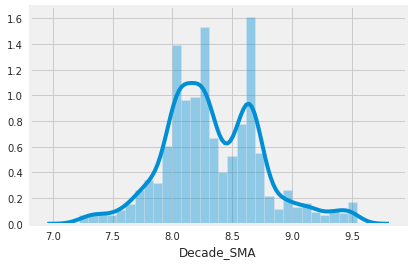

In [37]:
# Slightly Symetric 
%matplotlib inline
import seaborn as sns
sns.distplot(df['Decade_SMA']);

### Part 3 Baseline

In [38]:
train = df[0:1800]
val = df[900:1800]
test = df[1800:2970]
print(test.shape)
print(val.shape)
print(train.shape)

(1170, 12)
(900, 12)
(1800, 12)


In [39]:
# Assign to X, y let try average temps by year instead of sma of decade
target = 'Decade_SMA'
features = df.columns.drop('Decade_SMA')
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]
#Check Shapes
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(1800, 11)
(1800,)
(900, 11)
(900,)
(1170, 11)
(1170,)


In [40]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
lr = make_pipeline(
    ce.TargetEncoder(),  
    StandardScaler(),
    LinearRegression())
lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 0.6153901446888066


In [41]:
coefficients = lr.named_steps['linearregression'].coef_
pd.Series(coefficients, features).sort_values()

Yearly_SMA_CarbonTotal   -6.543607e+00
Year                     -1.700006e-01
Yearly_SMA_Gas_Fuel      -8.508939e-02
Yearly_SMA_Per_Capita    -1.776357e-15
Yearly_SMA_Cement         5.551115e-17
Yearly_SMA_Gas_Flaring    1.054712e-15
Yearly_SMA_Liquid_Fuel    7.191855e-03
month                     7.216319e-03
Average_Temps             9.496611e-03
Global_Warming            1.534826e-01
Yearly_SMA_Solid_Fuel     6.837875e+00
dtype: float64

In [42]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1))
gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.9879227229057833


- Lets look at shap

In [43]:
#Start of carbon emmisions
cutoff = pd.to_datetime('1900-01-01')
train1 = df[df.index < cutoff]
test1  = df[df.index >= cutoff]
# Assign to X, y
features2 = ['Yearly_SMA_CarbonTotal','Yearly_SMA_Per_Capita','month','Global_Warming',
             'Yearly_SMA_Gas_Flaring','Year','Yearly_SMA_Cement','Yearly_SMA_Gas_Fuel',
             'Yearly_SMA_Solid_Fuel','Yearly_SMA_Liquid_Fuel','Average_Temps']
target2 = 'Decade_SMA'
X_train2 = train1[features2]
y_train2 = train1[target2]
X_test2 = test1[features2]
y_test2 = test1[target2]
print(df.shape)
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(2970, 12)
(1638, 11)
(1638,)
(1332, 11)
(1332,)


In [46]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), }
search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=4, 
    scoring='neg_mean_absolute_error', 
    verbose=50, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42)
search.fit(X_test2, y_test2);

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   

In [47]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 20, 'max_features': 0.9507143064099162, 'n_estimators': 156}
Cross-validation MAE 0.19443531040704226


In [48]:
row = X_test2.iloc[[1300]]
row

,Yearly_SMA_CarbonTotal,Yearly_SMA_Per_Capita,month,Global_Warming,Yearly_SMA_Gas_Flaring,Year,Yearly_SMA_Cement,Yearly_SMA_Gas_Fuel,Yearly_SMA_Solid_Fuel,Yearly_SMA_Liquid_Fuel,Average_Temps
Datetime,,,,,,,,,,,
2008-05-01,8656.416667,1.288333,5,1,69.25,2008,384.5,1596.583333,3508.583333,3098.083333,12.054


In [49]:
#Eval Predictor
y_test2.iloc[[1300]]

Datetime
2008-05-01    9.471175
Name: Decade_SMA, dtype: float64

In [50]:
#What does the model predict for this Temperature
model.predict(row)

array([9.47029693])

In [51]:
# Why did the model predict this?
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [52]:
row = X_train2.iloc[[100]]
row

,Yearly_SMA_CarbonTotal,Yearly_SMA_Per_Capita,month,Global_Warming,Yearly_SMA_Gas_Flaring,Year,Yearly_SMA_Cement,Yearly_SMA_Gas_Fuel,Yearly_SMA_Solid_Fuel,Yearly_SMA_Liquid_Fuel,Average_Temps
Datetime,,,,,,,,,,,
1770-08-01,3.0,0.0,8,0,0.0,1770,0.0,0.0,3.0,0.0,11.413


In [53]:
#Eval Predictor
y_train2.iloc[[100]]

Datetime
1770-08-01    8.119533
Name: Decade_SMA, dtype: float64

In [54]:
#What does the model predict for this Temperature
model.predict(row)

array([8.16058686])

In [55]:
# Why did the model predict this?
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [56]:
def predict(Yearly_SMA_CarbonTotal,Yearly_SMA_Per_Capita,month,Global_Warming,
             Yearly_SMA_Gas_Flaring,Year,Yearly_SMA_Cement,Yearly_SMA_Gas_Fuel,
             Yearly_SMA_Solid_Fuel,Yearly_SMA_Liquid_Fuel,Average_Temps):
    # Make dataframe from the inputs
    pf = pd.DataFrame(
        data=[[Yearly_SMA_CarbonTotal,Yearly_SMA_Per_Capita,month,Global_Warming,
             Yearly_SMA_Gas_Flaring,Year,Yearly_SMA_Cement,Yearly_SMA_Gas_Fuel,
             Yearly_SMA_Solid_Fuel,Yearly_SMA_Liquid_Fuel,Average_Temps]], 
        columns=['Yearly_SMA_CarbonTotal','Yearly_SMA_Per_Capita','month','Global_Warming',
             'Yearly_SMA_Gas_Flaring','Year','Yearly_SMA_Cement','Yearly_SMA_Gas_Fuel',
             'Yearly_SMA_Solid_Fuel','Yearly_SMA_Liquid_Fuel','Average_Temps'])

    # Get the model's prediction
    pred = model.predict(pf)[0]

    # Calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(pf)

    # Get series with shap values, feature names, & feature values
    feature_names = pf.columns
    feature_values = pf.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

    # Print results
    result = f'{pred:,.0f} estimated Decade Average Temparature \n\n'
    #result += f'Starting from baseline of ${explainer.expected_value:,.0f} \n'
    result += shaps.to_string()
    print(result)
    # Show shapley values force plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=pf)
predict(40000, 2, 12,1,10000,2050,10000,10000,10000,5000,10)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


10 estimated Decade Average Temparature 

(Yearly_SMA_CarbonTotal, 40000)    0.179102
(Yearly_SMA_Per_Capita, 2)         0.008539
(month, 12)                        0.000569
(Global_Warming, 1)                0.000217
(Yearly_SMA_Gas_Flaring, 10000)   -0.003402
(Year, 2050)                       0.060627
(Yearly_SMA_Cement, 10000)         0.280933
(Yearly_SMA_Gas_Fuel, 10000)       0.235005
(Yearly_SMA_Solid_Fuel, 10000)     0.073250
(Yearly_SMA_Liquid_Fuel, 5000)     0.031021
(Average_Temps, 10)                0.000283


In [57]:
test1.tail()

,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Average_Temps
Datetime,,,,,,,,,,,,
2010-08-01,8,2010,9.520117,1,3768.0,1663.00,437.666667,61.333333,1.313333,3094.666667,9024.666667,14.768
2010-09-01,9,2010,9.522750,1,3786.5,1672.75,440.750000,60.750000,1.317500,3099.500000,9060.250000,12.863
2010-10-01,10,2010,9.530717,1,3805.0,1682.50,443.833333,60.166667,1.321667,3104.333333,9095.833333,10.442
2010-11-01,11,2010,9.540508,1,3823.5,1692.25,446.916667,59.583333,1.325833,3109.166667,9131.416667,7.487
2010-12-01,12,2010,9.544083,1,3842.0,1702.00,450.000000,59.000000,1.330000,3114.000000,9167.000000,4.292


### Part 4 Baseline visualized

In [58]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import math
plt.style.use('fivethirtyeight')

In [59]:
df2 = pd.DataFrame(index=df.index)
df2['baseline']=df['Average_Temps'].mean()
print(df2.shape)
df2.head()

(2970, 1)


,baseline
Datetime,
1761-10-01,8.370691
1761-11-01,8.370691
1762-01-01,8.370691
1762-02-01,8.370691
1762-03-01,8.370691


In [60]:
print(df.shape)
df.describe()

(2970, 12)


,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Average_Temps
count,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000
mean,6.518182,1886.620539,8.339950,0.414141,701.358418,191.401684,35.053535,13.615993,0.257497,515.093939,1456.495286,8.370691
std,3.448389,71.651864,0.412514,0.492656,864.692458,398.277173,78.318491,26.648685,0.460562,942.592184,2258.948078,4.299048
min,1.000000,1761.000000,7.220025,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.131000
25%,4.000000,1825.000000,8.054294,0.000000,16.354167,0.000000,0.000000,0.000000,0.000000,0.000000,16.354167,4.357250
50%,7.000000,1887.000000,8.281392,0.000000,278.500000,2.000000,0.000000,0.000000,0.000000,5.000000,285.083333,8.618000
75%,10.000000,1949.000000,8.629850,1.000000,1061.208333,76.729167,14.291667,0.000000,0.000000,362.291667,1439.104167,12.465750
max,12.000000,2010.000000,9.544083,1.000000,3842.000000,1702.000000,450.000000,110.000000,1.330000,3122.000000,9167.000000,15.462000


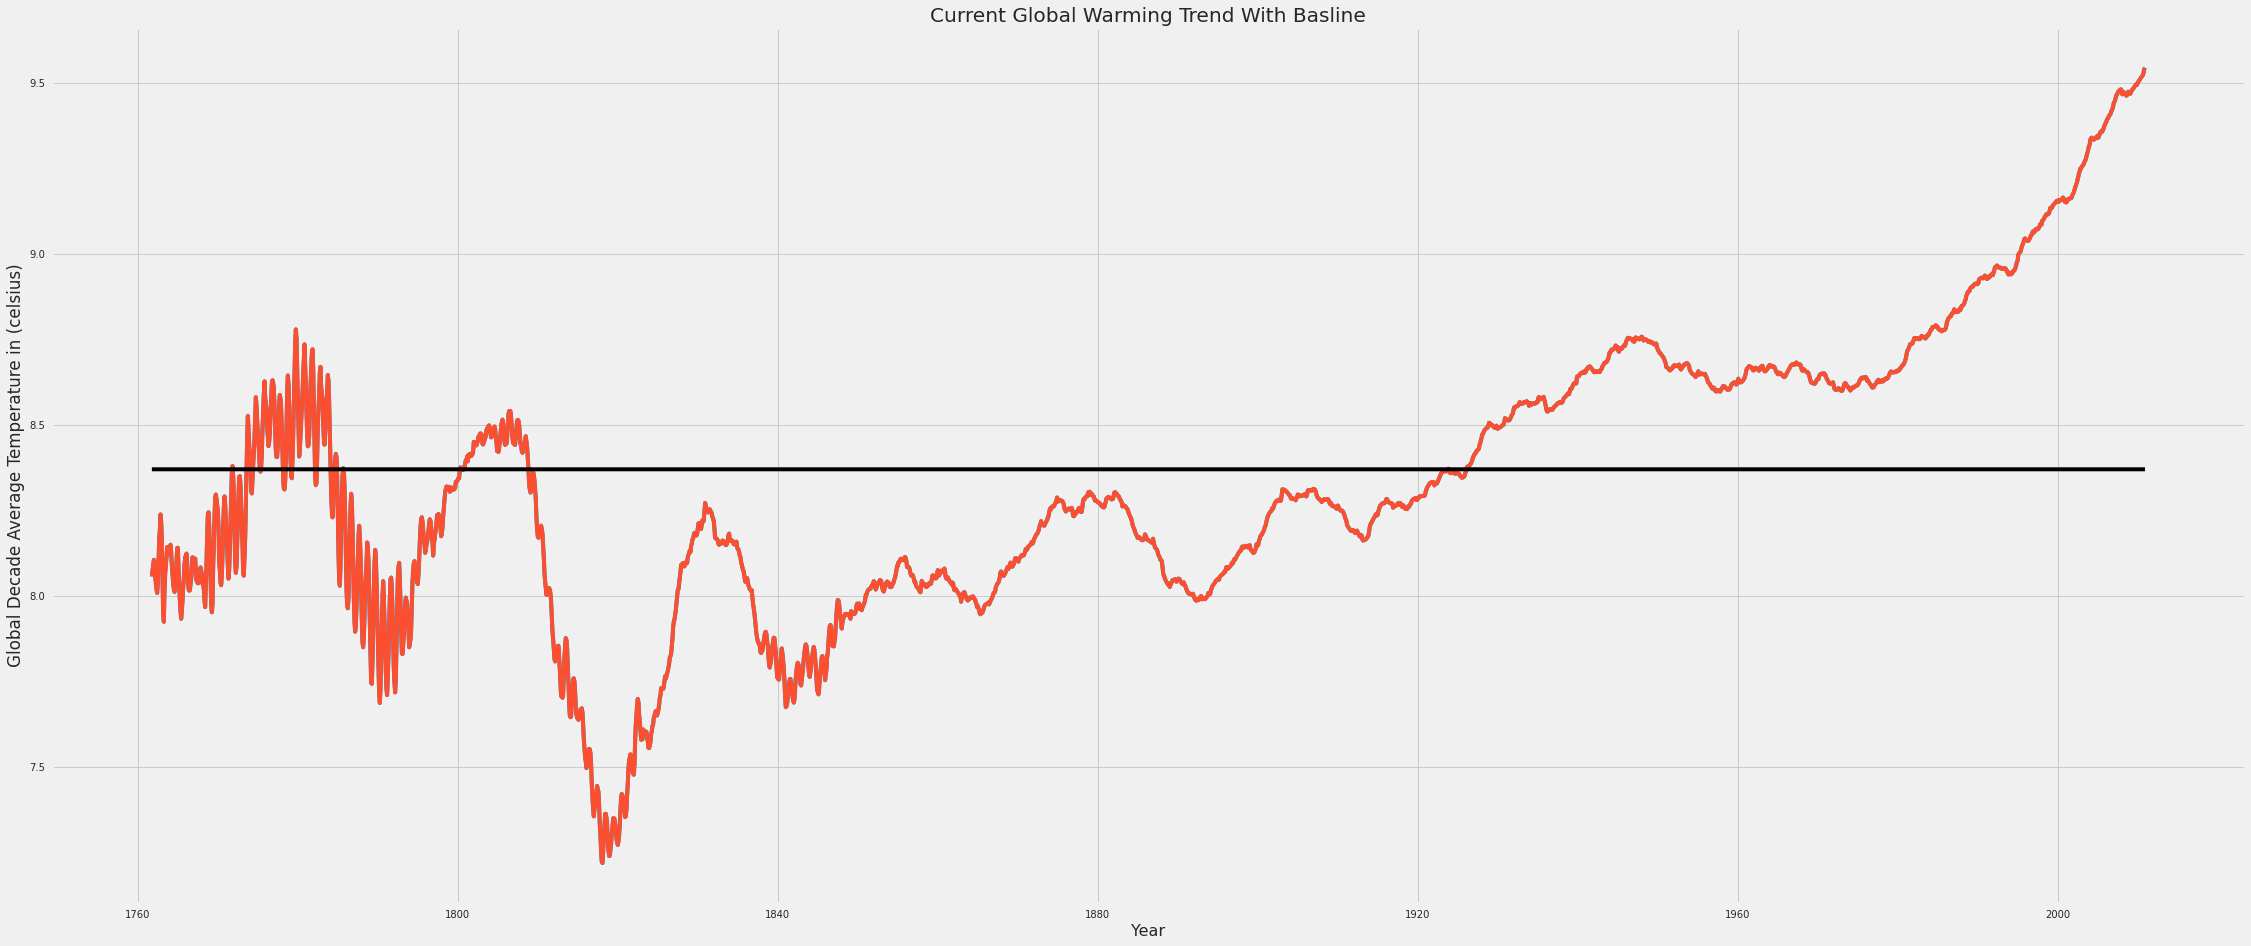

In [61]:
#Baseline
plt.figure(figsize=(35,15))
plt.title('Current Global Warming Trend With Basline')
plt.plot(df['Decade_SMA'])
plt.plot(df['Decade_SMA'])
plt.plot(df2['baseline'], color='black')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Global Decade Average Temperature in (celsius)');

### Part 5 Prep Dataframe 

In [65]:
df['Datetime']= df.index

In [66]:
P = df.drop(['Average_Temps','Datetime'], axis=1)
P

,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal
Datetime,,,,,,,,,,,
1761-10-01,10,1761,8.057650,0,3.0,0.00,0.000000,0.000000,0.000000,0.000000,3.000000
1761-11-01,11,1761,8.074775,0,3.0,0.00,0.000000,0.000000,0.000000,0.000000,3.000000
1762-01-01,1,1762,8.106300,0,3.0,0.00,0.000000,0.000000,0.000000,0.000000,3.000000
1762-02-01,2,1762,8.099425,0,3.0,0.00,0.000000,0.000000,0.000000,0.000000,3.000000
1762-03-01,3,1762,8.058075,0,3.0,0.00,0.000000,0.000000,0.000000,0.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...
2010-08-01,8,2010,9.520117,1,3768.0,1663.00,437.666667,61.333333,1.313333,3094.666667,9024.666667
2010-09-01,9,2010,9.522750,1,3786.5,1672.75,440.750000,60.750000,1.317500,3099.500000,9060.250000
2010-10-01,10,2010,9.530717,1,3805.0,1682.50,443.833333,60.166667,1.321667,3104.333333,9095.833333


In [67]:
#Predicition until 2100 at current carbon emmision progression
Futuredf = pd.DataFrame(P, index=pd.date_range('2011-1-1', freq='1M', periods=1080))
#Futuredf['Decade_SMA'] = X[['Solid Fuel']].rolling(window=12).mean
#Futuredf['Datetime']= Futuredf.index
Futuredf['Year'] = Futuredf.index.year
Futuredf['month'] = Futuredf.index.month
Futuredf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1080 entries, 2011-01-31 to 2100-12-31
Freq: M
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month                   1080 non-null   int64  
 1   Year                    1080 non-null   int64  
 2   Decade_SMA              0 non-null      float64
 3   Global_Warming          0 non-null      float64
 4   Yearly_SMA_Solid_Fuel   0 non-null      float64
 5   Yearly_SMA_Gas_Fuel     0 non-null      float64
 6   Yearly_SMA_Cement       0 non-null      float64
 7   Yearly_SMA_Gas_Flaring  0 non-null      float64
 8   Yearly_SMA_Per_Capita   0 non-null      float64
 9   Yearly_SMA_Liquid_Fuel  0 non-null      float64
 10  Yearly_SMA_CarbonTotal  0 non-null      float64
dtypes: float64(9), int64(2)
memory usage: 101.2 KB


In [68]:
Futuredf

,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal
2011-01-31,1,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-28,2,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-31,3,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-30,4,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-05-31,5,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2100-08-31,8,2100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2100-09-30,9,2100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2100-10-31,10,2100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2100-11-30,11,2100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2970 entries, 1761-10-01 to 2010-12-01
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   month                   2970 non-null   int64         
 1   Year                    2970 non-null   int64         
 2   Decade_SMA              2970 non-null   float64       
 3   Global_Warming          2970 non-null   int64         
 4   Yearly_SMA_Solid_Fuel   2970 non-null   float64       
 5   Yearly_SMA_Gas_Fuel     2970 non-null   float64       
 6   Yearly_SMA_Cement       2970 non-null   float64       
 7   Yearly_SMA_Gas_Flaring  2970 non-null   float64       
 8   Yearly_SMA_Per_Capita   2970 non-null   float64       
 9   Yearly_SMA_Liquid_Fuel  2970 non-null   float64       
 10  Yearly_SMA_CarbonTotal  2970 non-null   float64       
 11  Average_Temps           2970 non-null   float64       
 12  Datetime                2970 n

In [104]:
X=pd.merge(P,Futuredf, how='outer', left_index=True, right_index=True)
X['Year'] = X.index.year
X['Month'] = X.index.month
X['Decade_SMA'] = X['Decade_SMA_x']
X['Global_Warming'] = X['Global_Warming_x']
X['Yearly_SMA_Solid_Fuel'] = X['Yearly_SMA_Solid_Fuel_x']
X['Yearly_SMA_Cement'] = X['Yearly_SMA_Gas_Fuel_x']
X['Yearly_SMA_Gas_Flaring'] = X['Yearly_SMA_Gas_Flaring_x']
X['Yearly_SMA_Per_Capita'] = X['Yearly_SMA_Per_Capita_x']
X['Yearly_SMA_Liquid_Fuel'] = X['Yearly_SMA_Liquid_Fuel_x']
X['Yearly_SMA_CarbonTotal'] = X['Yearly_SMA_CarbonTotal_x']
X['Yearly_SMA_Gas_Fuel'] = X['Yearly_SMA_Gas_Fuel_x']
X.drop('month_y', axis=1, inplace=True)
X.drop('Year_y', axis=1, inplace=True)
X.drop('Decade_SMA_y', axis=1, inplace=True)
X.drop('Global_Warming_y', axis=1, inplace=True)
X.drop('Yearly_SMA_Solid_Fuel_y', axis=1, inplace=True)
X.drop('Yearly_SMA_Gas_Fuel_y', axis=1, inplace=True)
X.drop('Yearly_SMA_Cement_y', axis=1, inplace=True)
X.drop('Yearly_SMA_Gas_Flaring_y', axis=1, inplace=True)
X.drop('Yearly_SMA_Per_Capita_y', axis=1, inplace=True)
X.drop('Yearly_SMA_Liquid_Fuel_y', axis=1, inplace=True)
X.drop('Yearly_SMA_CarbonTotal_y', axis=1, inplace=True)
X.drop('Decade_SMA_x', axis=1, inplace=True)
X.drop('Global_Warming_x', axis=1, inplace=True)
X.drop('Yearly_SMA_Solid_Fuel_x', axis=1, inplace=True)
X.drop('Yearly_SMA_Gas_Fuel_x', axis=1, inplace=True)
X.drop('Yearly_SMA_Gas_Flaring_x', axis=1, inplace=True)
X.drop('Yearly_SMA_Per_Capita_x', axis=1, inplace=True)
X.drop('Yearly_SMA_Liquid_Fuel_x', axis=1, inplace=True)
X.drop('Yearly_SMA_CarbonTotal_x', axis=1, inplace=True)
X.drop('Year_x', axis=1, inplace=True)
X.drop('month_x', axis=1, inplace=True)
X.drop('Yearly_SMA_Cement_x', axis=1, inplace=True)
#Fix NaN
X['Decade_SMA'] =  X['Decade_SMA'].fillna(X['Decade_SMA'].rolling(1081,min_periods=1).mean()*1.11)
X['Yearly_SMA_Solid_Fuel'] =  X['Yearly_SMA_Solid_Fuel'].fillna(X['Yearly_SMA_Solid_Fuel'].rolling(1081,min_periods=1).mean()*2.5)
X['Yearly_SMA_Gas_Fuel'] = X['Yearly_SMA_Gas_Fuel'].fillna(X['Yearly_SMA_Gas_Fuel'].rolling(1081,min_periods=1).mean()*3.3)
X['Yearly_SMA_Cement'] = X['Yearly_SMA_Cement'].fillna(X['Yearly_SMA_Cement'].rolling(1081,min_periods=1).mean())
X['Yearly_SMA_Gas_Flaring'] = X['Yearly_SMA_Gas_Flaring'].fillna(X['Yearly_SMA_Gas_Flaring'].rolling(1081,min_periods=1).mean()*1.7)
X['Yearly_SMA_Per_Capita'] = X['Yearly_SMA_Per_Capita'].fillna(X['Yearly_SMA_Per_Capita'].rolling(1081,min_periods=1).mean()*1.89)
X['Yearly_SMA_Liquid_Fuel'] = X['Yearly_SMA_Liquid_Fuel'].fillna(X['Yearly_SMA_Liquid_Fuel'].rolling(1081,min_periods=1).mean()*2.2)
X['Yearly_SMA_CarbonTotal'] = X['Yearly_SMA_CarbonTotal'].fillna(X['Yearly_SMA_CarbonTotal'].rolling(1081,min_periods=1).mean()*2.5)
#Global Warming if above mean temps of baseline
X['Global_Warming'] = (X['Decade_SMA']>= 8.370691)
X[["Global_Warming"]] *= 1
#X=X.fillna(0)
print(X.shape)
X.tail(10)

(4050, 11)


,Year,Month,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Yearly_SMA_Gas_Fuel
2100-03-31,2100,3,10.569124,1,9396.875,1658.125,104.762500,2.478262,6802.950000,22517.187500,5471.8125
2100-04-30,2100,4,10.570995,1,9420.000,1663.000,104.266667,2.482200,6808.266667,22561.666667,5487.9000
2100-05-31,2100,5,10.573195,1,9443.125,1667.875,103.770833,2.486137,6813.583333,22606.145833,5503.9875
2100-06-30,2100,6,10.575321,1,9466.250,1672.750,103.275000,2.490075,6818.900000,22650.625000,5520.0750
2100-07-31,2100,7,10.577600,1,9489.375,1677.625,102.779167,2.494012,6824.216667,22695.104167,5536.1625
2100-08-31,2100,8,10.580115,1,9512.500,1682.500,102.283333,2.497950,6829.533333,22739.583333,5552.2500
2100-09-30,2100,9,10.583311,1,9535.625,1687.375,101.787500,2.501887,6834.850000,22784.062500,5568.3375
2100-10-31,2100,10,10.587664,1,9558.750,1692.250,101.291667,2.505825,6840.166667,22828.541667,5584.4250
2100-11-30,2100,11,10.591948,1,9581.875,1697.125,100.795833,2.509762,6845.483333,22873.020833,5600.5125
2100-12-31,2100,12,10.593932,1,9605.000,1702.000,100.300000,2.513700,6850.800000,22917.500000,5616.6000


In [72]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4050 entries, 1761-10-01 to 2100-12-31
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Year                    4050 non-null   int64  
 1   Month                   4050 non-null   int64  
 2   Decade_SMA              4050 non-null   float64
 3   Global_Warming          4050 non-null   int64  
 4   Yearly_SMA_Solid_Fuel   4050 non-null   float64
 5   Yearly_SMA_Cement       4050 non-null   float64
 6   Yearly_SMA_Gas_Flaring  4050 non-null   float64
 7   Yearly_SMA_Per_Capita   4050 non-null   float64
 8   Yearly_SMA_Liquid_Fuel  4050 non-null   float64
 9   Yearly_SMA_CarbonTotal  4050 non-null   float64
 10  Yearly_SMA_Gas_Fuel     4050 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 379.7 KB


In [73]:
df.tail()

,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Average_Temps,Datetime
Datetime,,,,,,,,,,,,,
2010-08-01,8,2010,9.520117,1,3768.0,1663.00,437.666667,61.333333,1.313333,3094.666667,9024.666667,14.768,2010-08-01
2010-09-01,9,2010,9.522750,1,3786.5,1672.75,440.750000,60.750000,1.317500,3099.500000,9060.250000,12.863,2010-09-01
2010-10-01,10,2010,9.530717,1,3805.0,1682.50,443.833333,60.166667,1.321667,3104.333333,9095.833333,10.442,2010-10-01
2010-11-01,11,2010,9.540508,1,3823.5,1692.25,446.916667,59.583333,1.325833,3109.166667,9131.416667,7.487,2010-11-01
2010-12-01,12,2010,9.544083,1,3842.0,1702.00,450.000000,59.000000,1.330000,3114.000000,9167.000000,4.292,2010-12-01


In [114]:
select_year = X.loc[X['Year'] == 2011]
select_year.head(12)

,Year,Month,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Yearly_SMA_Gas_Fuel
2011-01-31,2011,1,9.723132,1,4085.234954,524.410648,63.654769,1.338339,3094.556667,9247.239583,1730.555139
2011-02-28,2011,2,9.723600,1,4087.093760,524.886546,63.713763,1.339579,3097.264597,9253.675278,1732.125602
2011-03-31,2011,3,9.724062,1,4088.981911,525.363404,63.772866,1.340822,3099.976531,9260.147843,1733.699235
2011-04-30,2011,4,9.724519,1,4090.899489,525.841226,63.832080,1.342067,3102.692479,9266.657382,1735.276045
2011-05-31,2011,5,9.724974,1,4092.846577,526.320012,63.891403,1.343314,3105.412454,9273.203996,1736.856041
2011-06-30,2011,6,9.725426,1,4094.823256,526.799767,63.950837,1.344564,3108.136465,9279.787791,1738.439233
2011-07-31,2011,7,9.725875,1,4096.829609,527.280493,64.010382,1.345816,3110.864525,9286.408869,1740.025628
2011-08-31,2011,8,9.726322,1,4098.865719,527.762193,64.070037,1.347070,3113.596645,9293.067335,1741.615238
2011-09-30,2011,9,9.726769,1,4100.931670,528.244869,64.129804,1.348326,3116.332836,9299.763293,1743.208069
2011-10-31,2011,10,9.727215,1,4103.027544,528.728525,64.189683,1.349585,3119.073109,9306.496849,1744.804132


In [75]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,4050.0,1931.655062,97.587320,1761.000000,1847.000000,1932.000000,2016.000000,2100.000000
Month,4050.0,6.513333,3.449376,1.000000,4.000000,7.000000,10.000000,12.000000
Decade_SMA,4050.0,8.784746,0.827615,7.220025,8.147083,8.564304,9.753009,10.593932
Global_Warming,4050.0,0.570370,0.495084,0.000000,0.000000,1.000000,1.000000,1.000000
Yearly_SMA_Solid_Fuel,4050.0,2086.478781,2516.597215,3.000000,45.812500,870.583333,4222.699004,9605.000000
Yearly_SMA_Cement,4050.0,406.775129,523.691674,0.000000,0.000000,26.000000,789.662232,1702.000000
Yearly_SMA_Gas_Flaring,4050.0,33.907108,41.231900,0.000000,0.000000,0.000000,78.635593,113.496795
Yearly_SMA_Per_Capita,4050.0,0.727196,0.887850,0.000000,0.000000,0.000000,1.426505,2.513700
Yearly_SMA_Liquid_Fuel,4050.0,1740.915807,2269.613857,0.000000,0.000000,151.708333,3283.738980,6850.800000
Yearly_SMA_CarbonTotal,4050.0,5022.937247,6515.774910,3.000000,45.812500,1025.875000,9705.832191,22917.500000


In [ ]:
#Time Series Predicition After Making Estimate

In [151]:
Y=pd.merge(P,Futuredf, how='outer', left_index=True, right_index=True)
Y['Year'] = Y.index.year
Y['Month'] = Y.index.month
Y['Decade_SMA'] = Y['Decade_SMA_x']
Y['Global_Warming'] = Y['Global_Warming_x']
Y['Yearly_SMA_Solid_Fuel'] = Y['Yearly_SMA_Solid_Fuel_x']
Y['Yearly_SMA_Cement'] = Y['Yearly_SMA_Gas_Fuel_x']
Y['Yearly_SMA_Gas_Flaring'] = Y['Yearly_SMA_Gas_Flaring_x']
Y['Yearly_SMA_Per_Capita'] = Y['Yearly_SMA_Per_Capita_x']
Y['Yearly_SMA_Liquid_Fuel'] = Y['Yearly_SMA_Liquid_Fuel_x']
Y['Yearly_SMA_CarbonTotal'] = Y['Yearly_SMA_CarbonTotal_x']
Y['Yearly_SMA_Gas_Fuel'] = Y['Yearly_SMA_Gas_Fuel_x']
Y.drop('month_y', axis=1, inplace=True)
Y.drop('Year_y', axis=1, inplace=True)
Y.drop('Decade_SMA_y', axis=1, inplace=True)
Y.drop('Global_Warming_y', axis=1, inplace=True)
Y.drop('Yearly_SMA_Solid_Fuel_y', axis=1, inplace=True)
Y.drop('Yearly_SMA_Gas_Fuel_y', axis=1, inplace=True)
Y.drop('Yearly_SMA_Cement_y', axis=1, inplace=True)
Y.drop('Yearly_SMA_Gas_Flaring_y', axis=1, inplace=True)
Y.drop('Yearly_SMA_Per_Capita_y', axis=1, inplace=True)
Y.drop('Yearly_SMA_Liquid_Fuel_y', axis=1, inplace=True)
Y.drop('Yearly_SMA_CarbonTotal_y', axis=1, inplace=True)
Y.drop('Decade_SMA_x', axis=1, inplace=True)
Y.drop('Global_Warming_x', axis=1, inplace=True)
Y.drop('Yearly_SMA_Solid_Fuel_x', axis=1, inplace=True)
Y.drop('Yearly_SMA_Gas_Fuel_x', axis=1, inplace=True)
Y.drop('Yearly_SMA_Gas_Flaring_x', axis=1, inplace=True)
Y.drop('Yearly_SMA_Per_Capita_x', axis=1, inplace=True)
Y.drop('Yearly_SMA_Liquid_Fuel_x', axis=1, inplace=True)
Y.drop('Yearly_SMA_CarbonTotal_x', axis=1, inplace=True)
Y.drop('Year_x', axis=1, inplace=True)
Y.drop('month_x', axis=1, inplace=True)
Y.drop('Yearly_SMA_Cement_x', axis=1, inplace=True)
#Fix NaN
Y['Decade_SMA'] =  Y['Decade_SMA'].fillna(Y['Decade_SMA'].rolling(1081,min_periods=1).mean()**.99)
Y['Yearly_SMA_Solid_Fuel'] =  Y['Yearly_SMA_Solid_Fuel'].fillna(Y['Yearly_SMA_Solid_Fuel'].rolling(1081,min_periods=1).mean()*2.5/5)
Y['Yearly_SMA_Gas_Fuel'] = Y['Yearly_SMA_Gas_Fuel'].fillna(Y['Yearly_SMA_Gas_Fuel'].rolling(1081,min_periods=1).mean()*3.3)
Y['Yearly_SMA_Cement'] = Y['Yearly_SMA_Cement'].fillna(Y['Yearly_SMA_Cement'].rolling(1081,min_periods=1).mean())
Y['Yearly_SMA_Gas_Flaring'] = Y['Yearly_SMA_Gas_Flaring'].fillna(Y['Yearly_SMA_Gas_Flaring'].rolling(1081,min_periods=1).mean()*1.7)
Y['Yearly_SMA_Per_Capita'] = Y['Yearly_SMA_Per_Capita'].fillna(Y['Yearly_SMA_Per_Capita'].rolling(1081,min_periods=1).mean()*1.89)
Y['Yearly_SMA_Liquid_Fuel'] = Y['Yearly_SMA_Liquid_Fuel'].fillna(Y['Yearly_SMA_Liquid_Fuel'].rolling(1081,min_periods=1).mean()*2.2)
Y['Yearly_SMA_CarbonTotal'] = Y['Yearly_SMA_CarbonTotal'].fillna(Y['Yearly_SMA_CarbonTotal'].rolling(1081,min_periods=1).mean()*2.5)
#Global Warming if above mean temps of baseline
Y['Global_Warming'] = (Y['Decade_SMA']>= 8.370691)
Y[["Global_Warming"]] *= 1
#X=X.fillna(0)
print(Y.shape)
Y.tail(10)

(4050, 11)


,Year,Month,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Yearly_SMA_Gas_Fuel
2100-03-31,2100,3,9.309554,1,1879.375,1658.125,104.762500,2.478262,6802.950000,22517.187500,5471.8125
2100-04-30,2100,4,9.311185,1,1884.000,1663.000,104.266667,2.482200,6808.266667,22561.666667,5487.9000
2100-05-31,2100,5,9.313104,1,1888.625,1667.875,103.770833,2.486137,6813.583333,22606.145833,5503.9875
2100-06-30,2100,6,9.314958,1,1893.250,1672.750,103.275000,2.490075,6818.900000,22650.625000,5520.0750
2100-07-31,2100,7,9.316945,1,1897.875,1677.625,102.779167,2.494012,6824.216667,22695.104167,5536.1625
2100-08-31,2100,8,9.319138,1,1902.500,1682.500,102.283333,2.497950,6829.533333,22739.583333,5552.2500
2100-09-30,2100,9,9.321925,1,1907.125,1687.375,101.787500,2.501887,6834.850000,22784.062500,5568.3375
2100-10-31,2100,10,9.325721,1,1911.750,1692.250,101.291667,2.505825,6840.166667,22828.541667,5584.4250
2100-11-30,2100,11,9.329457,1,1916.375,1697.125,100.795833,2.509762,6845.483333,22873.020833,5600.5125
2100-12-31,2100,12,9.331187,1,1921.000,1702.000,100.300000,2.513700,6850.800000,22917.500000,5616.6000


In [152]:
select_year = Y.loc[Y['Year'] == 2011]
select_year.head(12)

,Year,Month,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Yearly_SMA_Gas_Fuel
2011-01-31,2011,1,8.571531,1,817.046991,524.410648,63.654769,1.338339,3094.556667,9247.239583,1730.555139
2011-02-28,2011,2,8.571938,1,817.418752,524.886546,63.713763,1.339579,3097.264597,9253.675278,1732.125602
2011-03-31,2011,3,8.572342,1,817.796382,525.363404,63.772866,1.340822,3099.976531,9260.147843,1733.699235
2011-04-30,2011,4,8.572741,1,818.179898,525.841226,63.832080,1.342067,3102.692479,9266.657382,1735.276045
2011-05-31,2011,5,8.573138,1,818.569315,526.320012,63.891403,1.343314,3105.412454,9273.203996,1736.856041
2011-06-30,2011,6,8.573532,1,818.964651,526.799767,63.950837,1.344564,3108.136465,9279.787791,1738.439233
2011-07-31,2011,7,8.573924,1,819.365922,527.280493,64.010382,1.345816,3110.864525,9286.408869,1740.025628
2011-08-31,2011,8,8.574314,1,819.773144,527.762193,64.070037,1.347070,3113.596645,9293.067335,1741.615238
2011-09-30,2011,9,8.574705,1,820.186334,528.244869,64.129804,1.348326,3116.332836,9299.763293,1743.208069
2011-10-31,2011,10,8.575094,1,820.605509,528.728525,64.189683,1.349585,3119.073109,9306.496849,1744.804132


In [153]:
df.tail(12)

,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Average_Temps,Datetime
Datetime,,,,,,,,,,,,,
2010-01-01,1,2010,9.500450,1,3638.5,1594.75,416.083333,65.416667,1.284167,3060.833333,8775.583333,3.737,2010-01-01
2010-02-01,2,2010,9.502242,1,3657.0,1604.50,419.166667,64.833333,1.288333,3065.666667,8811.166667,4.399,2010-02-01
2010-03-01,3,2010,9.506567,1,3675.5,1614.25,422.250000,64.250000,1.292500,3070.500000,8846.750000,6.738,2010-03-01
2010-04-01,4,2010,9.507558,1,3694.0,1624.00,425.333333,63.666667,1.296667,3075.333333,8882.333333,9.671,2010-04-01
2010-05-01,5,2010,9.511992,1,3712.5,1633.75,428.416667,63.083333,1.300833,3080.166667,8917.916667,12.406,2010-05-01
2010-06-01,6,2010,9.515000,1,3731.0,1643.50,431.500000,62.500000,1.305000,3085.000000,8953.500000,14.421,2010-06-01
2010-07-01,7,2010,9.518042,1,3749.5,1653.25,434.583333,61.916667,1.309167,3089.833333,8989.083333,15.213,2010-07-01
2010-08-01,8,2010,9.520117,1,3768.0,1663.00,437.666667,61.333333,1.313333,3094.666667,9024.666667,14.768,2010-08-01
2010-09-01,9,2010,9.522750,1,3786.5,1672.75,440.750000,60.750000,1.317500,3099.500000,9060.250000,12.863,2010-09-01


### Part 5 (LSTM) model for predicting future Global Warming at current Carbon Pollution Progression

In [ ]:
# Tuesday (LSTM) to predict future global warming temperatures with carbon emmisions and then wihtout carbon emmisions

In [78]:
data = X.filter(['Decade_SMA'])
#Convert dataframe numpy array
dataset=data.values
#Get the number of rows to train the model on 
train_len = math.ceil(len(dataset) *.5)
train_len

2025

In [79]:
#data = df.filter(['Decade_SMA'])
#Convert dataframe numpy array
#dataset=data.values
#Get the number of rows to train the model on 
#train_len = math.ceil(len(dataset) *.9)
#train_len

In [80]:
dataset

array([[ 8.05765   ],
       [ 8.074775  ],
       [ 8.1063    ],
       ...,
       [10.58766408],
       [10.59194837],
       [10.5939325 ]])

In [81]:
train_len

2025

In [82]:
#Scale
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.24826555],
       [0.25334127],
       [0.26268503],
       ...,
       [0.99814209],
       [0.99941192],
       [1.        ]])

In [83]:
#Training datat set and scaled traiing data set
train_data = scaled_data[0:train_len , :]
#Spilt the data into X_trian and y_train data sets
X_train=[]
y_train = []
for i in range(60, len(train_data)):
  X_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=61:
    print(X_train)
    print(y_train)

[array([0.24826555, 0.25334127, 0.26268503, 0.26064734, 0.24839152,
       0.2420833 , 0.23700511, 0.23391523, 0.2420833 , 0.26091656,
       0.27957445, 0.28861688, 0.30196441, 0.2953524 , 0.27978933,
       0.24754186, 0.21585506, 0.2089343 , 0.23450554, 0.25047367,
       0.26494996, 0.27369106, 0.26924518, 0.26801515, 0.27133722,
       0.27387137, 0.27569418, 0.26889939, 0.25826385, 0.24984137,
       0.24152016, 0.23746699, 0.23489826, 0.23918113, 0.25068609,
       0.26360879, 0.27284882, 0.27310322, 0.25389206, 0.2413522 ,
       0.2280763 , 0.21832746, 0.21160183, 0.21857693, 0.22731556,
       0.23925029, 0.24744306, 0.25864669, 0.26483882, 0.26802256,
       0.2601163 , 0.24807783, 0.23782266, 0.23598503, 0.23608383,
       0.24098665, 0.2466181 , 0.25281023, 0.26488821, 0.26104993])]
[0.2567670670714546]
[array([0.24826555, 0.25334127, 0.26268503, 0.26064734, 0.24839152,
       0.2420833 , 0.23700511, 0.23391523, 0.2420833 , 0.26091656,
       0.27957445, 0.28861688, 0.3019

In [84]:
#Convert X_train and y_train to arrays to use in model
X_train, y_train = np.array(X_train), np.array(y_train)
#Reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1965, 60, 1)

In [85]:
#LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
# Compile and optimize
model.compile(optimizer='adam', loss='mean_squared_error')

In [86]:
#Train Model
model.fit(X_train, y_train, batch_size=6,epochs=5)

Epoch 1/5
1965/1965 [==============================] - 18s 9ms/step - loss: 0.0014
Epoch 2/5
1965/1965 [==============================] - 17s 9ms/step - loss: 4.5809e-04
Epoch 3/5
1965/1965 [==============================] - 17s 9ms/step - loss: 4.8420e-04
Epoch 4/5
1965/1965 [==============================] - 17s 9ms/step - loss: 3.8392e-04
Epoch 5/5
1965/1965 [==============================] - 17s 9ms/step - loss: 3.7431e-04


In [87]:
#Test Dataset
test_data = scaled_data[train_len - 60: , :]
X_test = []
y_test = dataset[train_len:, :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60:i, 0])
#Covert to array 
X_test = np.array(X_test)

In [88]:
#Reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Predict Future Global Warming
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred) 

In [89]:
#Eval LSTM Model - (.0115 degress celius off best model last was .1944) -root mean squared error
rmse = np.sqrt( np.mean(y_pred-y_test)**2)
print(rmse)

0.03590814840760204


In [90]:
#bigger Baseline
df3 = pd.DataFrame(index=X.index)
df3['baseline']=df2['baseline'].mean()
print(df3.shape)
df3.head()

(4050, 1)


,baseline
1761-10-01,8.370691
1761-11-01,8.370691
1762-01-01,8.370691
1762-02-01,8.370691
1762-03-01,8.370691



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


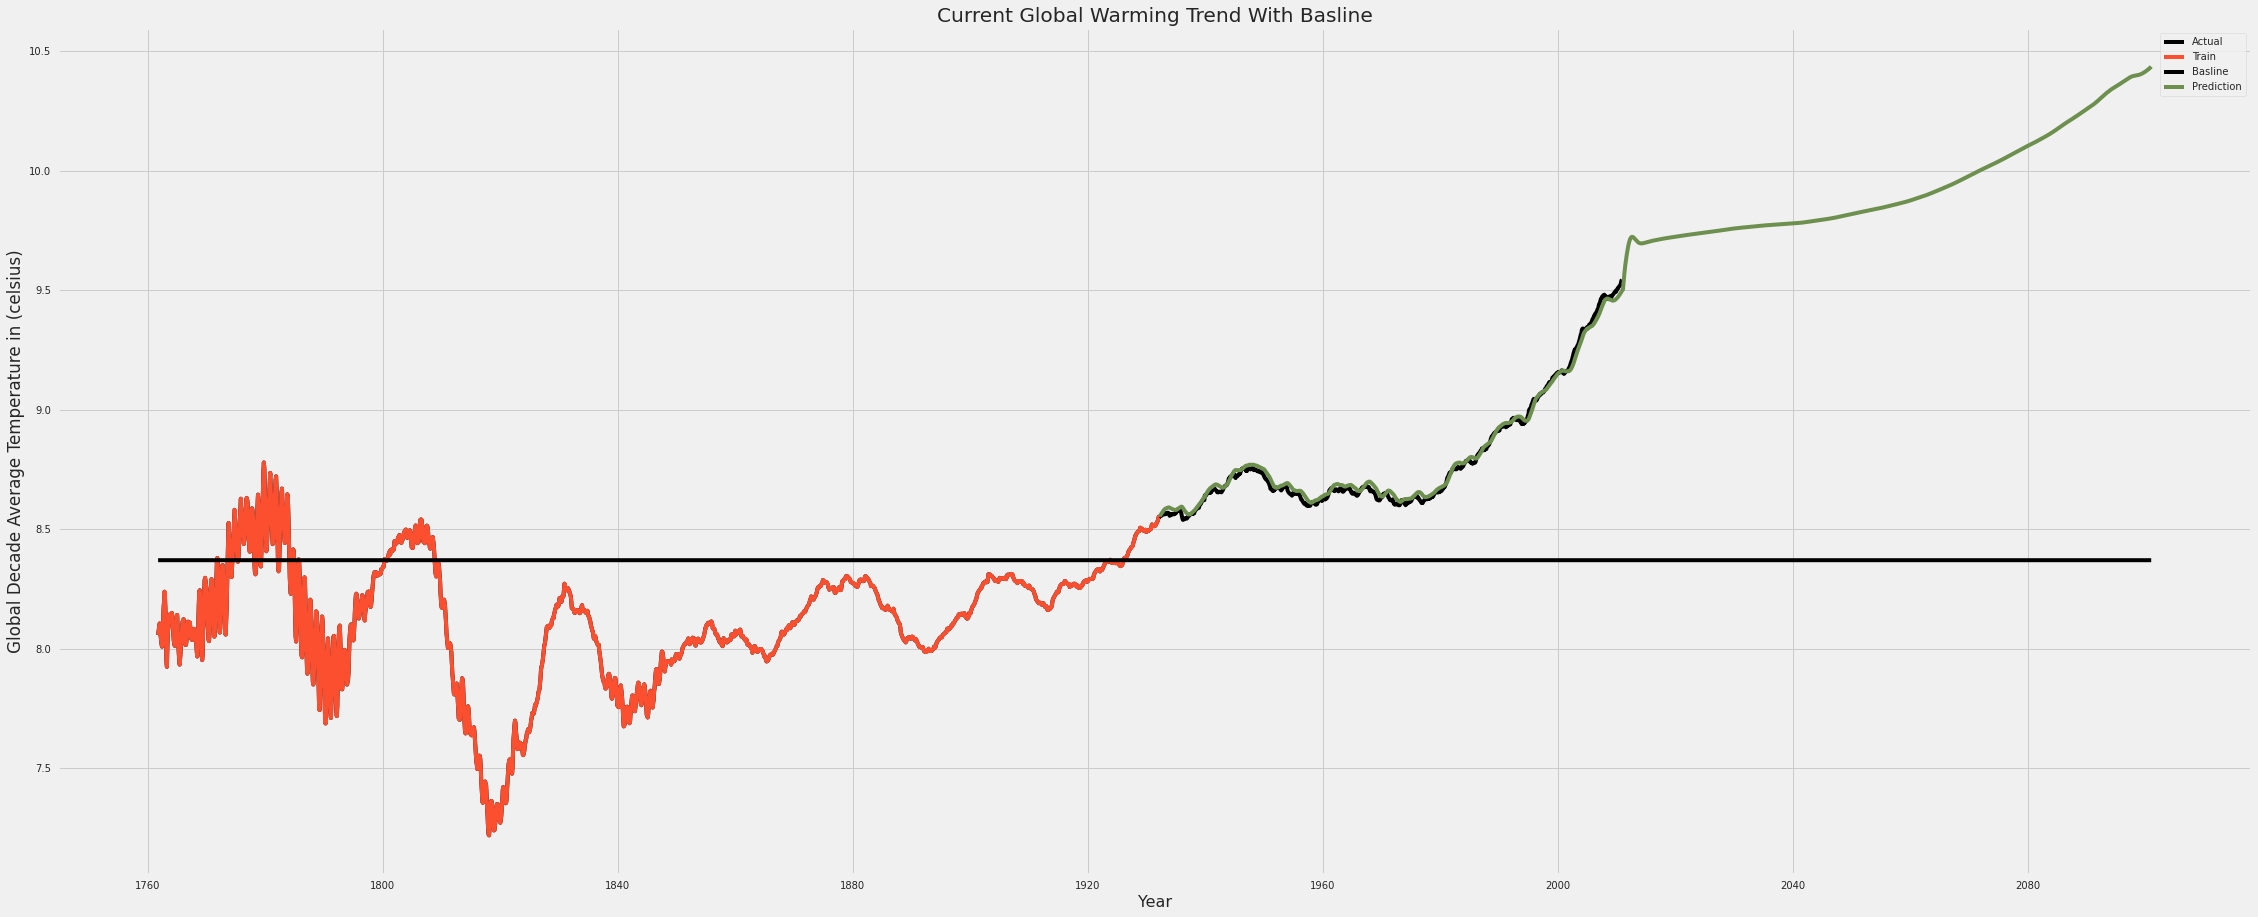

In [93]:
# Validate 41
Train = data[:train_len]
Val = data[train_len:]
Val['y_pred'] = y_pred
#Plot with baseline
plt.figure(figsize=(35,14.5))
plt.title('Current Global Warming Trend With Basline')
plt.plot(df['Decade_SMA'], Color='Black')
plt.plot(Train)
plt.plot(df3['baseline'], Color='Black')
plt.plot(Val[['y_pred']])
plt.legend(['Actual','Train','Basline','Prediction','Actual'])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Global Decade Average Temperature in (celsius)');

### Part 6 (LSTM) model for predicting future Global Cooling at slow limitation of Carbon Pollution 